# Optimal probabilistic clustering - Part II
> ...

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [Clustering, Entropy, Membership Entropy]
- image: images/post_image_optimal_clustering.png
- hide: false
- search_exclude: false
- author: Joao Rodrigues

In [1]:
######################################## Part I
from fcmeans import FCM

def run_cluster(n_clusters, features, random_state=42):
    # membership probabilities
    model = FCM(n_clusters=n_clusters, random_state=random_state, max_iter=1000, error=1e-9).fit(features)
    p = model.u
    # representative cluster
    representative_cluster = np.argmax(p, 1)
    # membership entropy
    Sx = -np.sum(p*np.log(p), 1) / np.log(n_clusters)
    # total membership entropy (across the entire feature space)
    S = np.sum(Sx)        
    
    return p, representative_cluster, Sx, S



## Experimental results

In [2]:
import numpy as np

(n,k,m) n observations, k clusters, at least m observations per cluster

In [3]:
def construct_random_partition(n, k, m, seed=None):
    rand = np.random.RandomState(seed=seed)
    parts = rand.choice(range(1, n-k*(m-1)), k-1, replace=False)
    parts.sort()
    parts = np.append(parts, n-k*(m-1))
    parts = np.append(parts[0], np.diff(parts)) - 1 + m
    
    return parts

In [4]:
partition = construct_random_partition(n=100, k=5, m=2, seed=40)
print(partition)

[13 26 22 33  6]


**Generation of random datasets**

In [5]:
def generate_random_dataset(partition, n_features, std, seed):
    random_state = np.random.RandomState(seed=seed)
    dataset = list()
    for n in partition:
        # cluster centre coordinates
        cluster_centre = random_state.uniform(-1, 1, n_features)
        # observation coordinates
        for observation in range(0, n):
            dataset.append(cluster_centre+std*random_state.standard_normal(n_features))
    dataset = np.array(dataset)
    # shuffles the observations
    dataset = dataset[random_state.permutation(dataset.shape[0]), :]
    
    return np.array(dataset)

In [6]:
dataset = generate_random_dataset(partition=partition, n_features=2, std=0.05, seed=42)

In [7]:
n_clusters_trials = np.arange(2, 15, 1)
total_entropies = list()
for trial in n_clusters_trials:
    _, _, _, total_entropy = run_cluster(n_clusters=trial, features=dataset, random_state=20)
    total_entropies.append(total_entropy)
    

In [8]:
optimal_nclusters = n_clusters_trials[np.argmin(total_entropies)]
print(optimal_nclusters)

2


In [9]:
p, representative_cluster, Sx, S = run_cluster(n_clusters=optimal_nclusters, features=dataset)

**Cluster quality**

In [11]:
Si_iter1 = dict()
for clust in set(representative_cluster):
    probs = p[np.argmax(p, 1)==clust, :]
    entropy = -np.sum(probs*np.log(probs), 1) / np.log(probs.shape[1])
    Si_iter1.update({clust: np.mean(entropy)})
    
_=[print("Mean membership entropy across cluster {0} = {1}".format(i, np.round(Si_iter1[i], 3))) for i in Si_iter1.keys()]

Mean membership entropy across cluster 0 = 0.149
Mean membership entropy across cluster 1 = 0.012


In [12]:
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
def make_rgb_transparent(rgb, alpha):
    bg_rgb = [1, 1, 1]
    return [alpha * c1 + (1 - alpha) * c2 for (c1, c2) in zip(rgb, bg_rgb)]
colormap = cm.get_cmap('Accent')
edgecolors = list()
facecolors = list()
for i in range(0, optimal_nclusters):
    edgecolors.append(make_rgb_transparent(rgb=colormap(1.0*i/(optimal_nclusters-1)), alpha=1))
    facecolors.append(make_rgb_transparent(rgb=colormap(1.0*i/(optimal_nclusters-1)), alpha=0.65))

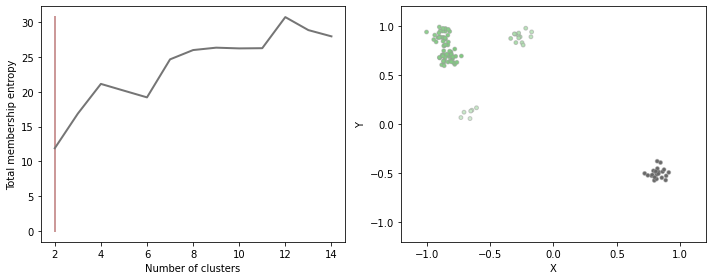

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot([optimal_nclusters, optimal_nclusters], [0, np.max(total_entropies)], color=(0.8,0.6,0.6), linewidth=2)
axes[0].plot(n_clusters_trials, total_entropies, color=(0.46,0.46,0.46), linewidth=2)
axes[0].set_xlabel('Number of clusters')
axes[0].set_ylabel('Total membership entropy')

color_seq = list()
for j in range(0, dataset.shape[0]):
    color_seq.append(make_rgb_transparent(edgecolors[representative_cluster[j]], 1-Sx[j]))
axes[1].scatter(dataset[:,0], dataset[:,1], marker='.', s=60, edgecolors=(0.6,0.6,0.6,0.5), c=color_seq)
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].set_xlim(-1.2,1.2)
axes[1].set_ylim(-1.2,1.2)

plt.tight_layout()
plt.show()

**Partition dataset**

In [14]:
bad_clusters = np.array(list(Si_iter1.keys()))[list(Si_iter1.values()) > np.mean(list(Si_iter1.values()))]
bad_clusters

array([0])

In [15]:
inds = []
for cluster in bad_clusters:
    inds += list(np.where(representative_cluster==cluster)[0])
inds = np.squeeze(np.array(inds))

In [16]:
dataset = dataset[inds,:]

**Repeat clustering on subsample**

In [17]:
n_clusters_trials = np.arange(2, 15, 1)
total_entropies = list()
for trial in n_clusters_trials:
    _, _, _, total_entropy = run_cluster(n_clusters=trial, features=dataset, random_state=20)
    total_entropies.append(total_entropy)

In [18]:
optimal_nclusters = n_clusters_trials[np.argmin(total_entropies)]
print(optimal_nclusters)

4


In [19]:
p, representative_cluster, Sx, S = run_cluster(n_clusters=optimal_nclusters, features=dataset)

In [33]:
Si_iter2 = dict()
for clust in set(representative_cluster):
    probs = p[np.argmax(p, 1)==clust, :]
    entropy = -np.sum(probs*np.log(probs), 1) / np.log(probs.shape[1])
    Si_iter2.update({clust: np.mean(entropy)})
    
_=[print("Mean membership entropy across cluster {0} = {1}".format(i, np.round(Si_iter2[i], 3))) for i in Si_iter2.keys()]

Mean membership entropy across cluster 0 = 0.073
Mean membership entropy across cluster 1 = 0.104
Mean membership entropy across cluster 2 = 0.223
Mean membership entropy across cluster 3 = 0.263


In [34]:
score = np.mean(list(Si_iter2.values()))

print(score)

[Si_iter1[bad_cluster] for bad_cluster in bad_clusters]

0.16589962648261908


[0.14913771991069089]

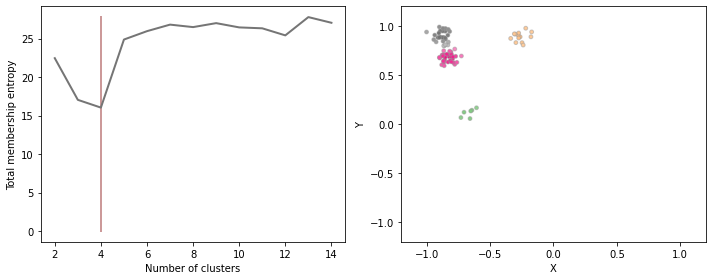

In [35]:
edgecolors = list()
facecolors = list()
for i in range(0, optimal_nclusters):
    edgecolors.append(make_rgb_transparent(rgb=colormap(1.0*i/(optimal_nclusters-1)), alpha=1))
    facecolors.append(make_rgb_transparent(rgb=colormap(1.0*i/(optimal_nclusters-1)), alpha=0.65))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot([optimal_nclusters, optimal_nclusters], [0, np.max(total_entropies)], color=(0.8,0.6,0.6), linewidth=2)
axes[0].plot(n_clusters_trials, total_entropies, color=(0.46,0.46,0.46), linewidth=2)
axes[0].set_xlabel('Number of clusters')
axes[0].set_ylabel('Total membership entropy')

color_seq = list()
for j in range(0, dataset.shape[0]):
    color_seq.append(make_rgb_transparent(edgecolors[representative_cluster[j]], 1-Sx[j]))
axes[1].scatter(dataset[:,0], dataset[:,1], marker='.', s=60, edgecolors=(0.6,0.6,0.6,0.5), c=color_seq)
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].set_xlim(-1.2,1.2)
axes[1].set_ylim(-1.2,1.2)


plt.tight_layout()
plt.show()

**Resample dataset**:

In [37]:
bad_clusters = np.array(list(Si_iter2.keys()))[list(Si_iter2.values()) > np.mean(list(Si_iter2.values()))]
bad_clusters

array([2, 3])

In [38]:
inds = []
for cluster in bad_clusters:
    inds += list(np.where(representative_cluster==cluster)[0])
inds = np.squeeze(np.array(inds))

In [39]:
dataset = dataset[inds,:]

**Repeat process**

In [50]:
n_clusters_trials = np.arange(2, 15, 1)
total_entropies = list()
for trial in n_clusters_trials:
    _, _, _, total_entropy = run_cluster(n_clusters=trial, features=dataset, random_state=20)
    total_entropies.append(total_entropy)

In [51]:
optimal_nclusters = n_clusters_trials[np.argmin(total_entropies)]
print(optimal_nclusters)

2


In [52]:
p, representative_cluster, Sx, S = run_cluster(n_clusters=optimal_nclusters, features=dataset)

In [53]:
Si = dict()
for clust in set(representative_cluster):
    probs = p[np.argmax(p, 1)==clust, :]
    entropy = -np.sum(probs*np.log(probs), 1) / np.log(probs.shape[1])
    Si.update({clust: np.mean(entropy)})
    
_=[print("Mean membership entropy across cluster {0} = {1}".format(i, np.round(Si[i], 3))) for i in Si.keys()]

Mean membership entropy across cluster 0 = 0.406
Mean membership entropy across cluster 1 = 0.31


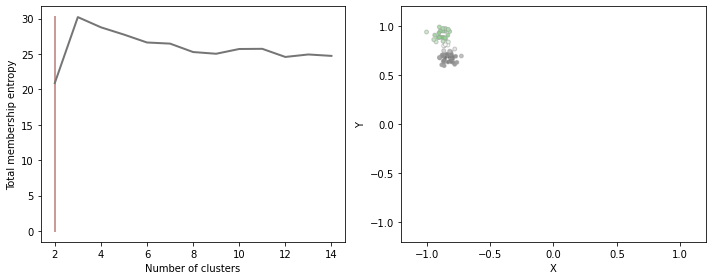

In [54]:
edgecolors = list()
facecolors = list()
for i in range(0, optimal_nclusters):
    edgecolors.append(make_rgb_transparent(rgb=colormap(1.0*i/(optimal_nclusters-1)), alpha=1))
    facecolors.append(make_rgb_transparent(rgb=colormap(1.0*i/(optimal_nclusters-1)), alpha=0.65))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot([optimal_nclusters, optimal_nclusters], [0, np.max(total_entropies)], color=(0.8,0.6,0.6), linewidth=2)
axes[0].plot(n_clusters_trials, total_entropies, color=(0.46,0.46,0.46), linewidth=2)
axes[0].set_xlabel('Number of clusters')
axes[0].set_ylabel('Total membership entropy')

color_seq = list()
for j in range(0, dataset.shape[0]):
    color_seq.append(make_rgb_transparent(edgecolors[representative_cluster[j]], 1-Sx[j]))
axes[1].scatter(dataset[:,0], dataset[:,1], marker='.', s=60, edgecolors=(0.6,0.6,0.6,0.5), c=color_seq)
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].set_xlim(-1.2,1.2)
axes[1].set_ylim(-1.2,1.2)

plt.tight_layout()
plt.show()

In [99]:
def d(x,y):
    rho = np.corrcoef(x, y)[0,1]
    #return np.sqrt(1-np.abs(rho)) 
    return np.sqrt(0.5*(1-rho))

In [107]:
noise = 0.9
x1 = np.random.normal(0,1,100000)
x2 = x1+noise*np.random.normal(0,1,100000)
x3 = (x1+x2)/2

In [109]:
print(d(x1,x2))
print(d(x1,x3))
print(d(x2,x3))

0.3572698702445935
0.2090727907887914
0.15409999771790703


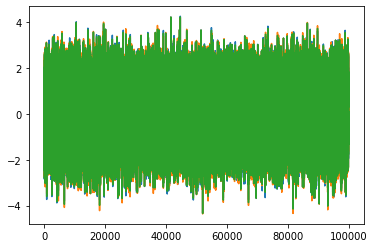

In [104]:
plt.plot(x1)
plt.plot(x2)
plt.plot(x3)
plt.show()



Initialize fcmeans with different seeds the do statistics would probably help



**References:**

{% bibliography --cited %}